# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.7 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=df61e1417a4940b3f02ca8b07b2a6678fa4b3e4e99b789e7ad99db4a190eac40
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=8f1eaf78a41cdf3629b2d967b59760796f2c2fa3aa563f061d933cc6ecae3b36
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found exist

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, TSLA
STOCK = 'TSLA'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
u01759794_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [5]:
u01759794_df.head()

,open,high,low,close,adjclose,volume,ticker
2020-11-17,153.389999,154.000000,144.336670,147.203339,147.203339,183564900,TSLA
2020-11-18,149.449997,165.333328,147.833328,162.213333,162.213333,234132000,TSLA
2020-11-19,164.000000,169.536667,162.523331,166.423340,166.423340,187425900,TSLA
2020-11-20,165.996674,167.500000,163.020004,163.203339,163.203339,98735700,TSLA
2020-11-23,167.833328,175.333328,167.263336,173.949997,173.949997,150780900,TSLA


In [6]:
!date

Sun Nov 26 01:19:51 AM UTC 2023


In [7]:
%connect_info

{
  "shell_port": 1,
  "iopub_port": 2,
  "stdin_port": 3,
  "control_port": 4,
  "hb_port": 5,
  "ip": "/root/.local/share/jupyter/runtime/kernel-32a08067-9047-4161-ae2e-83b41838e63a-ipc",
  "key": "",
  "transport": "ipc",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-32a08067-9047-4161-ae2e-83b41838e63a.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [8]:
# remove columns which our neural network will not use
u01759794_df = u01759794_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
u01759794_df['date'] = u01759794_df.index

In [9]:
u01759794_df

,close,date
2020-11-17,147.203339,2020-11-17
2020-11-18,162.213333,2020-11-18
2020-11-19,166.423340,2020-11-19
2020-11-20,163.203339,2020-11-20
2020-11-23,173.949997,2020-11-23
...,...,...
2023-11-17,234.300003,2023-11-17
2023-11-20,235.600006,2023-11-20
2023-11-21,241.199997,2023-11-21
2023-11-22,234.210007,2023-11-22


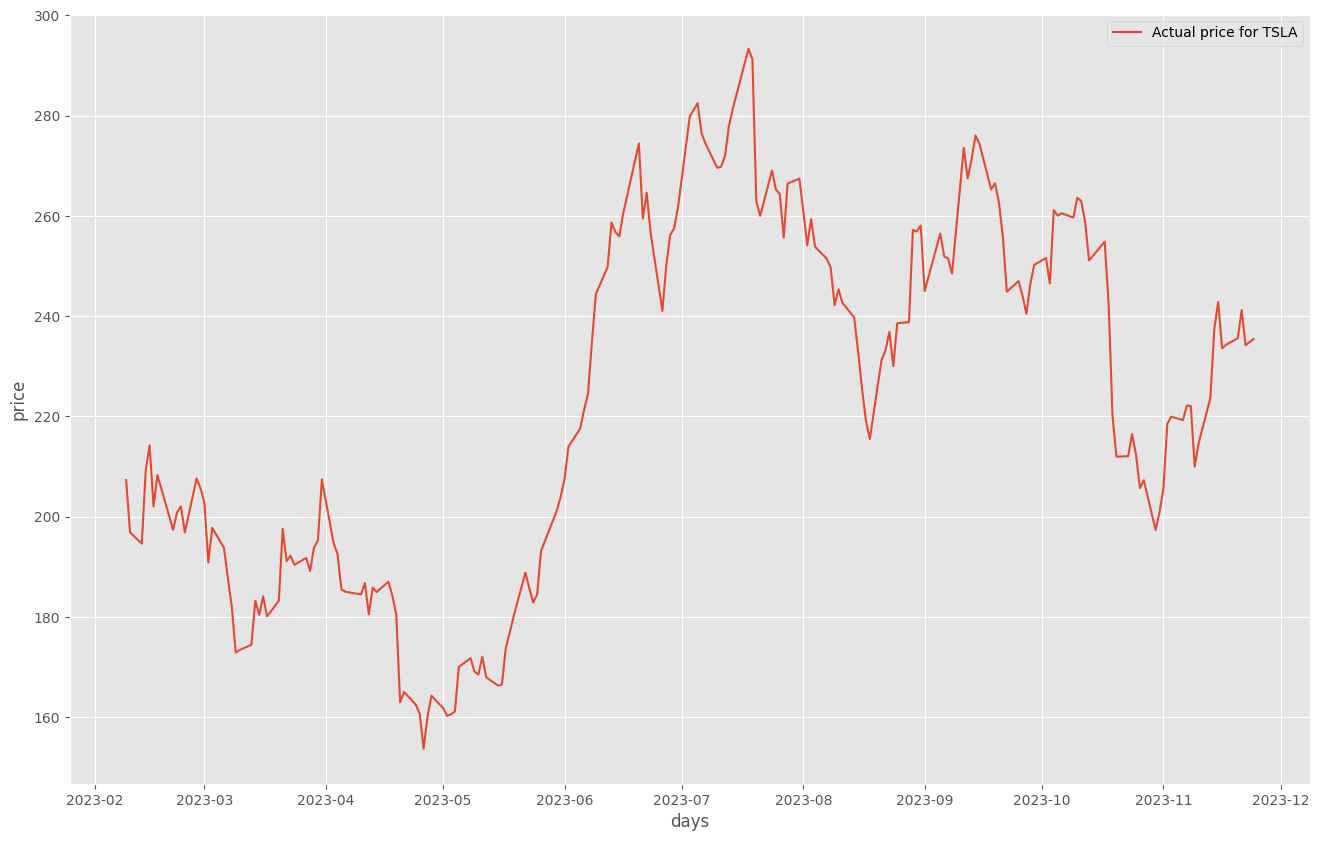

In [10]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(u01759794_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [11]:
# Scale data for ML engine
scaler = MinMaxScaler()
u01759794_df['scaled_close'] = scaler.fit_transform(np.expand_dims(u01759794_df['close'].values, axis=1))

In [12]:
u01759794_df

,close,date,scaled_close
2020-11-17,147.203339,2020-11-17,0.129537
2020-11-18,162.213333,2020-11-18,0.179260
2020-11-19,166.423340,2020-11-19,0.193207
2020-11-20,163.203339,2020-11-20,0.182540
2020-11-23,173.949997,2020-11-23,0.218140
...,...,...,...
2023-11-17,234.300003,2023-11-17,0.418061
2023-11-20,235.600006,2023-11-20,0.422367
2023-11-21,241.199997,2023-11-21,0.440918
2023-11-22,234.210007,2023-11-22,0.417763


In [13]:
def PrepareData(days):
  df = u01759794_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [14]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2020-11-17  147.203339 2020-11-17      0.129537  0.182540
 2020-11-18  162.213333 2020-11-18      0.179260  0.218140
 2020-11-19  166.423340 2020-11-19      0.193207  0.255165
 2020-11-20  163.203339 2020-11-20      0.182540  0.275726
 2020-11-23  173.949997 2020-11-23      0.218140  0.288711
 ...                ...        ...           ...       ...
 2023-11-14  237.410004 2023-11-14      0.428363  0.418061
 2023-11-15  242.839996 2023-11-15      0.446351  0.422367
 2023-11-16  233.589996 2023-11-16      0.415709  0.440918
 2023-11-17  234.300003 2023-11-17      0.418061  0.417763
 2023-11-20  235.600006 2023-11-20      0.422367  0.421870
 
 [757 rows x 4 columns],
 array([[0.3529665 ],
        [0.38297945],
        [0.4283632 ],
        [0.44635108],
        [0.41570875],
        [0.41806078],
        [0.42236727],
        [0.44091827],
        [0.41776264],
        [0.42187032]], dtype=float32),
 array([[[0.1295370185614394

In [15]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [16]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 19s 6ms/step - loss: 0.0179
Epoch 2/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 3/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0053
Epoch 4/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0049
Epoch 5/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0045
Epoch 6/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 7/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0042
Epoch 8/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0035
Epoch 9/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0036
Epoch 10/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0029
Epoch 11/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0028
Epoch 12/80
95/95 [==============================] - 1s 7ms/step - loss: 0.0027
Epoch 13/80
95/95 [=============================

In [17]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

TSLA prediction for upcoming 3 days (237.69$, 233.69$, 228.05$)


In [19]:
# Execute model for the whole history range
copy_u01759794_df = u01759794_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_u01759794_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 4ms/step


In [20]:
copy_u01759794_df

,close,date,scaled_close,predicted_close
2020-11-17,147.203339,2020-11-17,0.129537,194.919998
2020-11-18,162.213333,2020-11-18,0.179260,189.606674
2020-11-19,166.423340,2020-11-19,0.193207,197.793335
2020-11-20,163.203339,2020-11-20,0.182540,199.679993
2020-11-23,173.949997,2020-11-23,0.218140,213.919998
...,...,...,...,...
2023-11-17,234.300003,2023-11-17,0.418061,227.745987
2023-11-20,235.600006,2023-11-20,0.422367,227.984314
2023-11-21,241.199997,2023-11-21,0.440918,241.199997
2023-11-22,234.210007,2023-11-22,0.417763,234.210007


In [21]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_u01759794_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_u01759794_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_u01759794_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

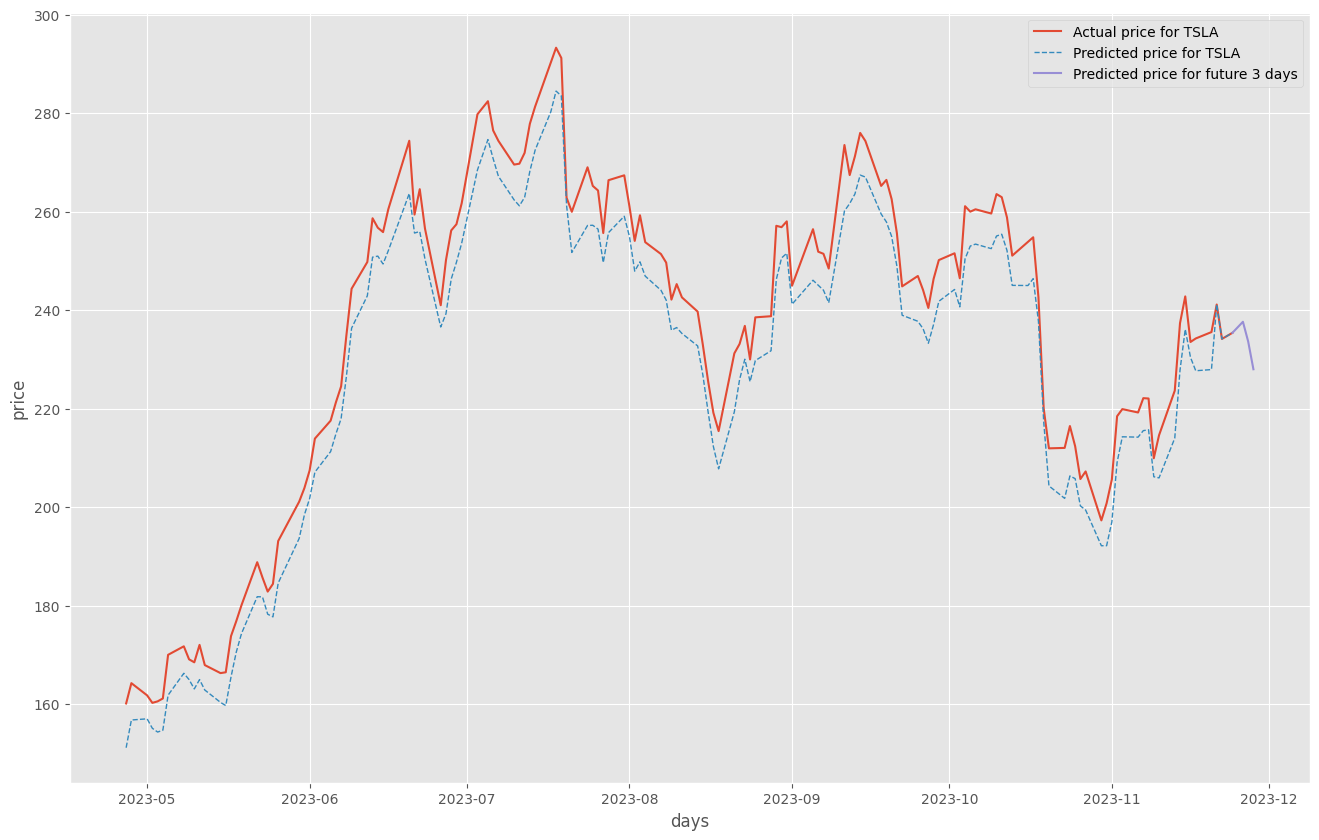

In [22]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_u01759794_df['close'][-150:].head(147))
plt.plot(copy_u01759794_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_u01759794_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()